*Notebook conventions:*

* <font color="red">assignment problem</font>. The red color indicates the task that should be done
* <font color="green">debugging</font>. The green tells you what is expected outcome. Its primarily goal is to help you get the correct answer
* <font color="blue">comments, hints</font>.

Assignment 2 (Simple network)
======================



## Preliminaries

In [247]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# for compatability issues 
from __future__ import print_function

In [0]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [251]:
# to make interactive plotting possible
%matplotlib inline
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [0]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

# data type (useful to have in pytorch)
dtype_np = np.float64
dtype_torch = torch.FloatTensor

### Pathes

In [0]:
path_data = "drive/My Drive/Colab Notebooks/data/toy_data/data_class_train.txt"

### Data (playground)

In [0]:
# load data
data = np.loadtxt(path_data)
dataX = data[:,0:2]
dataY = data[:,2]

In [0]:
n_samples = data.shape[0]
dim_in = 2 # two features
dim_out = 3 # three classes

n_train = int(n_samples * 0.7)
n_test = n_samples - n_train

In [0]:
# train-test partition
perm = np.random.permutation(n_samples)
train_indx = perm[:n_train]
test_indx = perm[n_train:]

dataX_train, dataY_train = dataX[train_indx,:], dataY[train_indx]
dataX_test, dataY_test = dataX[test_indx,:], dataY[test_indx]

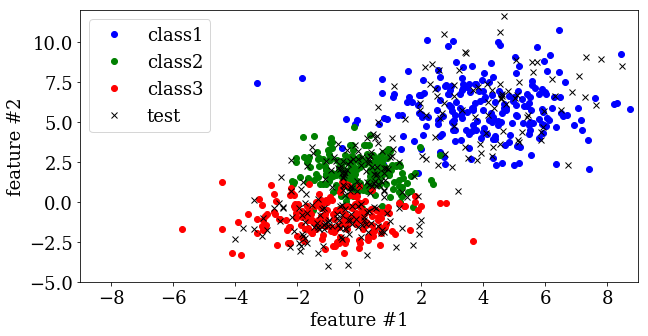

In [258]:
# visualize data
plt.figure(figsize=(10,5))
plt.plot(dataX_train[dataY_train==0,0], dataX_train[dataY_train==0,1],'ob', label="class1")
plt.plot(dataX_train[dataY_train==1,0], dataX_train[dataY_train==1,1],'og', label="class2")
plt.plot(dataX_train[dataY_train==2,0], dataX_train[dataY_train==2,1],'or', label="class3")

plt.plot(dataX_test[:,0], dataX_test[:,1],'xk', label="test")

plt.xlabel('feature #1')
plt.ylabel('feature #2')
plt.legend()
plt.xlim(-9, 9)
plt.ylim(-5, 12);

## Two-layer Network (by hand)


$$x_{hidden} = RELU(x  \cdot W_1 + b_1)$$
$$y_{pred} = x_{hidden} \cdot W_2 + b_2$$

In [0]:
dim_hidden = 100 # hidden dimension

In [0]:
# input 
x = torch.from_numpy(dataX_train).type(dtype_torch)
y = torch.from_numpy(dataY_train).type(torch.LongTensor)

* Weights and biases

 <font color="red"> **[PROBLEM I]**: </font>   
 <font color="red"> Fill the missing part (weights and biases for the output layer) </font>  

In [0]:
# Randomly initialize weights
w1_value = np.random.randn(dim_in, dim_hidden)
w2_value = np.random.randn(dim_hidden, dim_out)# YOUR CODE HERE

# Randomly initialize biases
b1_value = np.random.randn(dim_hidden)
b2_value =np.random.randn(dim_out)# YOUR CODE HERE

In [0]:
w1 = torch.from_numpy(w1_value).type(dtype_torch).requires_grad_(True)
w2 = torch.from_numpy(w2_value).type(dtype_torch).requires_grad_(True)
b1 = torch.from_numpy(b1_value).type(dtype_torch).requires_grad_(True)
b2 = torch.from_numpy(b2_value).type(dtype_torch).requires_grad_(True)

* Loss (we will use cross-entropy loss), see documentation for details http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss

In [0]:
criterion = nn.CrossEntropyLoss()

* learning parameters

In [0]:
learning_rate = 1e-3
n_iteration = 500

 <font color="red"> **[PROBLEM II]**: </font>   
 <font color="red"> Fill the missing part (last operation in forward pass to calculate *y_pred*) </font>  

In [265]:
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for t in range(n_iteration):  
 
    # forward pass
    x_hidden = x.mm(w1) + b1
    x_hidden_act = x_hidden.clamp(min=0) # apply RELU
    y_pred = x_hidden_act.mm(w2) + b2 # YOUR CODE HERE
    
    # compute loss
    loss = criterion(y_pred, y)

    # backprop
    loss.backward()

    # update weights using gradient descent  
    w1.data -= learning_rate * w1.grad
    w2.data -= learning_rate * w2.grad
    b1.data -= learning_rate * b1.grad
    b2.data -= learning_rate * b2.grad

    # manually zero the gradients
    w1.grad.zero_()
    w2.grad.zero_()
    b1.grad.zero_()
    b2.grad.zero_()      
    
    # reporting & logging       
    if t % 100 == 0:
        print(t, loss.item())
        
    logger['iteration'] += [t]
    logger['loss_iteration'] += [loss.item()]

0 20.01432228088379
100 1.3266934156417847
200 0.4813610315322876
300 0.3851568400859833
400 0.3476109206676483


 <font color="green"> After visualizing the loss (cell below) you should see something like this </font>

![loss_toy.png](https://drive.google.com/uc?id=1wzsrZQfIOFueYmFp5KnhG-iDFCnRkO_v)

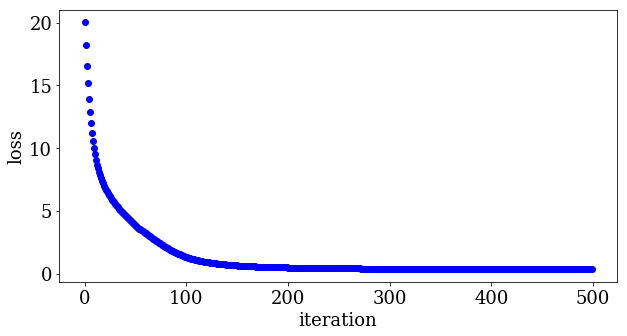

In [266]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

<font color="red"> **[PROBLEM III]**: </font>   
<font color="red"> Implement the fuction which takes x and predicts its class </font>  

In [0]:
def predict(x, w1, b1, w2, b2, dtype_torch=torch.FloatTensor):
    """
    Prediction based on two-layer model (by hand)
    
    Args:
        x (numpy.array): sample
        w1, b1, w2, b2 (torch.Tensor) : weights and biases 
    Returns:
        scalar: predicted class
    """
    t = torch.from_numpy(x).type(dtype_torch)
    forward_pass =  (t.matmul(w1) + b1).clamp(min=0).matmul(w2) + b2 # YOUR CODE HERE
    #t = torch.from_numpy(x).type(dtype_torch)
    #x_hidden = t.matmul(w1) + b1
    #x_hidden_act = x_hidden.clamp(min=0) # apply RELU
    #forward_pass = x_hidden_act.matmul(w2) + b2 # YOUR CODE HERE
    return np.argmax(forward_pass.data.numpy())

<span style="color:green"> by running the following command you should get number bigger than 8 </span>

In [325]:
np.sum(np.equal([predict(x, w1, b1, w2, b2) for x in dataX_train[:10]], [0, 2, 0, 1, 0, 2, 0, 0, 1, 0]))

10

* Calculate accuracy

In [0]:
def get_accuracy(y, y_pred):
    """
    Calculate accuracy given y and y_predicted
    
    Args:
        y (numpy.array): ground truth
        y_pred (numpy.array): predictated values
         
    Returns:
        scalar: accuracy
    """
    n_samples = y.shape[0]
    return np.sum(y == y_pred)/n_samples * 100

In [327]:
y_train_predict = np.zeros(n_train)
for i in range(n_train):
    y_train_predict[i] = predict(dataX_train[i], w1, b1, w2, b2)

print("Train accuracy: %f" % get_accuracy(y_train_predict, dataY_train))

Train accuracy: 92.698413


<font color="red"> **[PROBLEM IV]**: </font>   
<font color="red"> Calculate accuracy on the test set </font>

In [328]:
#YOUR CODE HERE
y_test_predict = np.zeros(n_test)
for i in range(n_test):
    y_test_predict[i] = predict(dataX_test[i], w1, b1, w2, b2)

print("Train accuracy: %f" % get_accuracy(y_test_predict, dataY_test))

Train accuracy: 91.111111


* Visualize decision boundary

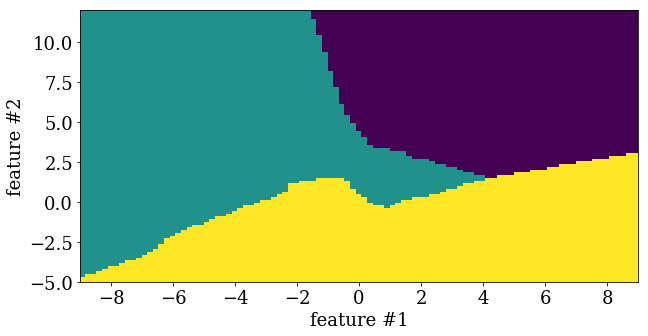

In [329]:
Nspace = 100
x1space = np.linspace(-9, 9, Nspace)
x2space = np.linspace(-5, 12, Nspace)
X,Y = np.meshgrid(x1space, x2space)

Z = np.zeros((Nspace,Nspace))
for i in range(Nspace):
    for j in range(Nspace):
        x1 = x1space[j]
        y1 = x2space[i]
        x = np.array([x1,y1])
        Z[i,j] = predict(x, w1, b1, w2, b2)

plt.figure(figsize=(10,5))
plt.pcolor(X, Y, Z, vmin=abs(Z).min(), vmax=abs(Z).max())

plt.xlabel('feature #1')
plt.ylabel('feature #2')
plt.xlim(-9, 9)
plt.ylim(-5, 12);

## Two-layer Network, again ...  (with nn package) 

$$x_{hidden} = RELU(x  \cdot W_1 + b_1)$$
$$y_{pred} = x_{hidden} \cdot W_2 + b_2$$

After some hard work we will use torch with all its power and elegance.  

* Model

In [0]:
class Net(nn.Module):
  
  def __init__(self, dim_in, dim_hidden, dim_out):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(dim_in, dim_hidden)
    self.fc2 = nn.Linear(dim_hidden, dim_out)
    
  def forward(self, x):
    x = self.fc2(F.relu(self.fc1(x)))
    return x

In [0]:
model = Net(dim_in, dim_hidden, dim_out)

* Loss (we will use cross-entropy loss)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
# input 
x = torch.from_numpy(dataX_train).type(dtype_torch)
y = torch.from_numpy(dataY_train).type(torch.LongTensor)

In [0]:
learning_rate = 1e-2
n_iteration = 1000

In [335]:
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for t in range(n_iteration):  
    
    # forward pass
    y_pred = model(x)
    
    # compute loss
    loss = criterion(y_pred, y)

    # backprop
    loss.backward()

    # update weights using gradient descent  
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data 
    
    # manually zero the gradients
    model.zero_grad()  
    
    # reporting & logging       
    if t % 100 == 0:
        print(t, loss.item())
        
    logger['iteration'] += [t]
    logger['loss_iteration'] += [loss.item()]

0 1.1708242893218994
100 0.31806641817092896
200 0.2541128396987915
300 0.22331269085407257
400 0.20437169075012207
500 0.19137053191661835
600 0.18183647096157074
700 0.1745341271162033
800 0.16876675188541412
900 0.16410531103610992


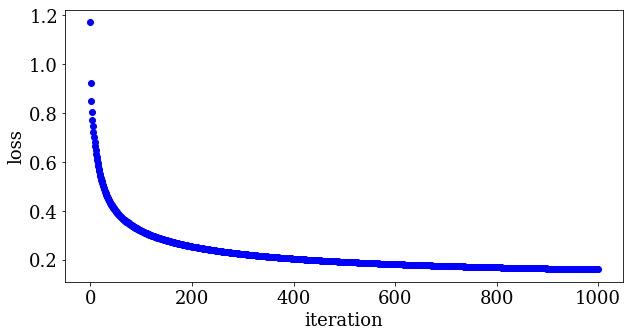

In [336]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

In [0]:
def predict(x, model):
    """
    Prediction based on two-layer model
    
    Args:
        x (numpy.array): feature vector of a sample
         
    Returns:
        scalar: predicted class for this sample
    """    
    t = torch.from_numpy(x).type(dtype_torch)
    forward_pass = model(t)
    return np.argmax(forward_pass.data.numpy(), axis=1)

In [338]:
y_train_predict = predict(dataX_train,model)
print("Train accuracy: %f" % get_accuracy(y_train_predict, dataY_train))

y_test_predict = predict(dataX_test, model)
print("Test accuracy: %f" % get_accuracy(y_test_predict, dataY_test))

Train accuracy: 95.238095
Test accuracy: 95.925926


<font color="red"> **[PROBLEM V]**: </font>   
<font color="red"> Try to implement & test network from DL course using pytorch and this toy dataset.

 </font>  
 
![tensor](https://drive.google.com/uc?id=1CteXB_bD36LzsopgIQRJymYMGdYq_ZL3)